### Load cross validation and testing data for normal vs COVID using the intersection of genes from top 100 DEGs of normal vs COVID and mild vs severe

In [16]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load training data (one patient at a time)
num_folds = 5
X_train = [[] for x in range(num_folds)] # make list of arrays to hold X data for each cell
X_validation = [[] for x in range(num_folds)] # make list of arrays to hold X data for each cell
y_train = [[] for x in range(num_folds)] # make list of arrays to hold X data for each cell
y_validation = [[] for x in range(num_folds)] # make list of arrays to hold X data for each cell

X_test = pd.read_csv('normal_vs_disease_test_data.csv')
y_test = pd.read_csv('normal_vs_disease_test_label.csv')
y_test = np.array(y_test.drop(columns=['Unnamed: 0']))

for i in range(num_folds):
    X_filename =  str(i+1) + '_fold_training' + '.csv'
    y_filename = str(i+1) + '_fold_training_label' + '.csv'

    X_train_temp = pd.read_csv(X_filename)
    y_train_temp = pd.read_csv(y_filename)

    # Drop unnecessary columns
    y_train_temp = np.array(y_train_temp.drop(columns=['Unnamed: 0']))

    
    X_filename2 =  str(i+1) + '_fold_testing' + '.csv'
    y_filename2 = str(i+1) + '_fold_testing_label' + '.csv'

    X_validation_temp = pd.read_csv(X_filename2)
    y_validation_temp = pd.read_csv(y_filename2)

    # Drop unnecessary columns
    y_validation_temp = np.array(y_validation_temp.drop(columns=['Unnamed: 0']))

    
    X_train[i] = X_train_temp
    y_train[i] = y_train_temp
    X_validation[i] = X_validation_temp
    y_validation[i] = y_validation_temp


In [5]:
top_gene=[]
with open ("intersection_mild_severe_and_normal_rest.txt") as f1:
    lines=f1.readlines()
    for line in lines:
        line=line.strip()
        top_gene.append(line)
        
print(top_gene)
index = X_train[0].columns.get_indexer(top_gene)  # find index of the top n features in the dataset
print(index)
X_test_new = X_test.iloc[:, index] # retain only the top n features in the data

['IL21', 'SPON1', 'IGFL2', 'IGHV3-69-1', 'IFNL2', 'CTSB', 'SFTA1P', 'PEG10', 'SAA2-SAA4', 'TMPRSS11D', 'RNASE7', 'CEACAM7', 'CRYBA4', 'KRT16', 'LGMN', 'GJA1', 'KRTAP3-1', 'SFTA2', 'FBXW10', 'ADGRF5', 'TRAV38-1', 'CYR61', 'CTSL', 'CTSE', 'S100A14', 'PLA2G7', 'CD52', 'KRT7', 'CLDN3', 'SLAMF7', 'HKDC1', 'SDS', 'SPP1', 'PFKFB3', 'SGK1', 'RGL1', 'FABP4', 'SFTPB', 'MAL2', 'CD3E', 'SFN', 'SPRR1B', 'LAMC2', 'TSHZ2', 'CALHM6']
[ 685 1699 1633  832 1720  912  842  689  831 1248  668  833  984  338
  387 1846 1180  248 1096 1121  279  438  337  455  198  781  852   49
  177  792 1094  288   21 1963  818 1588  125   70  634  363  103  153
 1599 1549  811]


In [6]:
feature_names = list(X_test.drop(columns=['Unnamed: 0']).columns)
print(feature_names)

['SLPI', 'SCGB1A1', 'SCGB3A1', 'IGLV3-19', 'IGHV4-34', 'WFDC2', 'BPIFB1', 'IGHG1', 'GNLY', 'MSMB', 'IGLC3', 'JCHAIN', 'CCL4L2', 'IGHG4', 'TFF3', 'LCN2', 'SERPINB3', 'S100A2', 'MUC5AC', 'AGR2', 'SPP1', 'IGKC', 'KRT17', 'KRT19', 'BPIFA1', 'HSPA6', 'LYPD2', 'IGHA1', 'CCL4', 'CCL8', 'SERPINB2', 'CCL2', 'CCL5', 'PI3', 'GZMB', 'IGLC2', 'CCL3L1', 'MT1G', 'IGHV3-30', 'TMEM190', 'IGLV2-14', 'TACSTD2', 'IGHM', 'CAPS', 'KRT4', 'CXCL8', 'CCL18', 'CRYAB', 'KRT7', 'CDC20B', 'IGKV3-20', 'CCL7', 'TPPP3', 'MZB1', 'HBB', 'CLDN4', 'CXCL13', 'C20orf85', 'CXCL10', 'S100P', 'TRBV12-4', 'AQP5', 'CXCL17', 'KRT13', 'DNAJB1', 'MT1H', 'C9orf24', 'PIGR', 'GSTA1', 'SFTPB', 'TRBV7-2', 'HSPA1A', 'IFNB1', 'G0S2', 'HSPA1B', 'KRT6A', 'TPSAB1', 'CCL17', 'APOC1', 'KRT8', 'SAA1', 'TRBV4-1', 'TPSB2', 'MT1M', 'S100A12', 'HAMP', 'TRBV7-9', 'TRBV11-2', 'TRBV20-1', 'IGHV3-23', 'NKG7', 'MS4A1', 'TM4SF1', 'C1orf194', 'IL32', 'TRDV1', 'MUC5B', 'SPINK1', 'TSPAN1', 'TRBV7-6', 'IGHV4-4', 'S100A8', 'SFN', 'CXCL9', 'IGLV3-25', 'SFTPA2

### Cell-level classification of normal and COVID using SVM and random forest

In [23]:
SVM_f1_cv=[]
rf_f1_cv=[]

for i2 in range(num_folds):
    print("fold "+str(i2+1))
    X_train_new = X_train[i2].iloc[:, index] # retain only the top n features in the data
    X_validation_new = X_validation[i2].iloc[:, index] # retain only the top n features in the data
    clf_select = SVC(kernel= 'rbf', class_weight='balanced', probability=True)
    clf_select.fit(X_train_new, y_train[i2])  # train the model using cross validation training set (9 patients)
    validation_pred = clf_select.predict(X_validation_new)  # predict using cross validation testing set (1 patient)
    f1_select = f1_score(y_validation[i2], validation_pred, average='weighted')
    SVM_f1_cv.append(f1_select)
    
    clf_rf = RandomForestClassifier(n_estimators = 100)
    clf_rf.fit(X_train_new, y_train[i2])
    validation_pred_rf = clf_rf.predict(X_validation_new)
    f1_rf = f1_score(y_validation[i2], validation_pred_rf, average='weighted')
    rf_f1_cv.append(f1_rf)

print("F1-score of cross validation of SVM "+str(SVM_f1_cv))
print(sum(SVM_f1_cv)/len(SVM_f1_cv))
print(np.std(SVM_f1_cv))
print("F1-score of cross validation of RF "+str(rf_f1_cv))
print(sum(rf_f1_cv)/len(rf_f1_cv))
print(np.std(rf_f1_cv))

fold 1
fold 2
fold 3
fold 4
fold 5
F1-score of cross validation of SVM [0.8623312924601887, 0.856385210666849, 0.8747524503144055, 0.8660056219550033, 0.8621167515832752]
0.8643182653959445
0.00605718530209638
F1-score of cross validation of RF [0.8893871614020912, 0.8836661284511128, 0.8999839293655302, 0.8929677049977467, 0.8869305378342733]
0.8905870924101509
0.005597817949361694


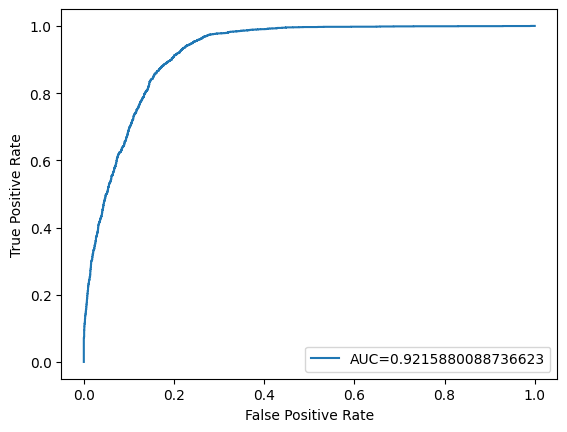

F1-score of SVM 0.8558359057770388
confusion matrix of SVM
[[2113  674]
 [ 152 2858]]


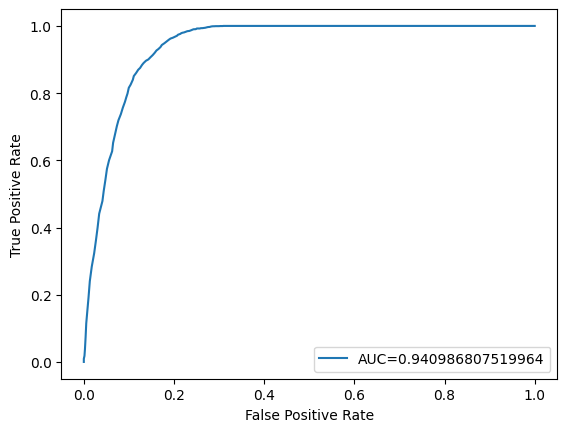

F1-score of random forest 0.8871951700419777
confusion matrix of RF
[[2261  526]
 [ 123 2887]]


In [29]:
test_pred = clf_select.predict(X_test_new)  # predict using cross validation testing set 
f1_select = f1_score(y_test, test_pred, average='weighted')
y_pred_proba = clf_select.predict_proba(X_test_new)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba, pos_label="Normal")
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
print("F1-score of SVM "+str(f1_select))
print("confusion matrix of SVM")
print(confusion_matrix(y_test, test_pred))

test_pred_rf = clf_rf.predict(X_test_new)
f1_rf = f1_score(y_test, test_pred_rf, average='weighted')
y_pred_proba2 = clf_rf.predict_proba(X_test_new)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_test,  y_pred_proba2, pos_label="Normal")
auc2 = metrics.roc_auc_score(y_test, y_pred_proba2)
plt.plot(fpr2,tpr2,label="AUC="+str(auc2))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
print("F1-score of random forest "+str(f1_rf))
print("confusion matrix of RF")
print(confusion_matrix(y_test, test_pred_rf))

### Load training and testing data and use the union of genes from top 100 DEGs of normal vs COVID and mild vs severe

In [30]:
top_gene2=[]

with open ("union_mild_severe_and_normal_rest_new.txt") as f2:
    lines2=f2.readlines()
    for line2 in lines2:
        line2=line2.strip()
        top_gene2.append(line2)

index2 = X_train[0].columns.get_indexer(top_gene2) 
print(top_gene2)
print(index2)
print(len(index2))

['CLDN3', 'TRAV6', 'SGK1', 'IL4I1', 'GJA1', 'KRT78', 'FABP4', 'S100A9', 'CXCL9', 'CYR61', 'ATF3', 'CD2', 'SMIM22', 'PLA2G7', 'ISG20', 'KLF6', 'RNASE7', 'LAMC2', 'S100A12', 'KRT7', 'MAFB', 'FTL', 'SPRR1B', 'IFNL2', 'PTPRCAP', 'SFN', 'SERPINB4', 'SAA2-SAA4', 'SFTA2', 'CD38', 'FBXW10', 'IDO1', 'FNIP2', 'TRBV11-3', 'C19orf33', 'GCH1', 'PEG10', 'IL21', 'CTSB', 'NUPR1', 'IGLV5-48', 'IFIT1', 'CTSL', 'ANKRD22', 'CTSE', 'CRYBA4', 'CCL2', 'CD7', 'SLAMF7', 'SPOCK2', 'HKDC1', 'HES4', 'FFAR2', 'C1QA', 'SPON1', 'IER3', 'SERPINB5', 'DUOX2', 'MARCKS', 'TNFSF13B', 'TRBV7-4', 'C1QB', 'FGL2', 'VAMP5', 'AQP1', 'AC114291.1', 'TGFBI', 'MAL2', 'TSHZ2', 'CEACAM7', 'ADGRF5', 'IGHV3-69-1', 'PRSS3', 'SFTPB', 'NR1H3', 'TNFSF10', 'PFKFB3', 'ANXA3', 'CXCL11', 'SPHK1', 'TYROBP', 'IGFL1', 'S100A14', 'CEACAM6', 'AC242022.1', 'IGFBP4', 'CD3E', 'IGHV5-51', 'PRSS22', 'TRDV3', 'CD48', 'NINJ1', 'CD1E', 'IFNL3', 'IL1RN', 'ICAM1', 'TRBV10-1', 'CTSD', 'TMPRSS11A', 'WIF1', 'GZMA', 'CCL8', 'SDS', 'C1QC', 'ADGRF4', 'TRAV38-2DV8'

In [31]:
SVM_f1_cv_new=[]
rf_f1_cv_new=[]
feature_importance_values = []

for i3 in range(num_folds):
    print("fold "+str(i3+1))
    X_train_new2 = X_train[i3].iloc[:, index2] # retain only the top n features in the data
    X_validation_new2 = X_validation[i3].iloc[:, index2] # retain only the top n features in the data
    clf_select2 = SVC(kernel= 'rbf', class_weight='balanced', probability=True)
    clf_select2.fit(X_train_new2, y_train[i3]) 
    validation_pred2 = clf_select2.predict(X_validation_new2)  
    f1_select2 = f1_score(y_validation[i3], validation_pred2, average='weighted')
    SVM_f1_cv_new.append(f1_select2)
    
    clf_rf2 = RandomForestClassifier(n_estimators = 100)
    clf_rf2.fit(X_train_new2, y_train[i3])
    validation_pred2_rf = clf_rf2.predict(X_validation_new2)
    f1_rf2 = f1_score(y_validation[i3], validation_pred2_rf, average='weighted')
    rf_f1_cv_new.append(f1_rf2)
    
    # Save feature importance values from each fold 
    feature_importance_values.append(clf_rf2.feature_importances_)

print("F1-score of cross validation of SVM "+str(SVM_f1_cv_new))
print(sum(SVM_f1_cv_new)/len(SVM_f1_cv_new))
print(np.std(SVM_f1_cv_new))
print("F1-score of cross validation of RF "+str(rf_f1_cv_new))
print(sum(rf_f1_cv_new)/len(rf_f1_cv_new))
print(np.std(rf_f1_cv_new))

fold 1
fold 2
fold 3
fold 4
fold 5
F1-score of cross validation of SVM [0.8917240071762648, 0.8902531142122538, 0.9019853756708411, 0.8993839889510261, 0.9004816213301897]
0.8967656214681152
0.004811256854769149
F1-score of cross validation of RF [0.9553495648794622, 0.9481998798157004, 0.9530559667312392, 0.9544392626346556, 0.9492831242647003]
0.9520655596651515
0.002831448026990612


No handles with labels found to put in legend.


154
[(0.07979727748492628, 'TRAV38-1'), (0.045759909306942306, 'TRBV7-4'), (0.044540675851313105, 'CXCL10'), (0.037132091739409755, 'TRBV11-3'), (0.03308406190044054, 'DUOX2'), (0.03011471489859882, 'SPRR1B'), (0.028628406134511092, 'RSAD2'), (0.0228629027399232, 'IL21'), (0.02202862616097872, 'IFNL3'), (0.02057011802946114, 'SFTA2'), (0.01940289367115188, 'TMPRSS11D'), (0.017870472681216634, 'ISG20'), (0.01754222255330994, 'WIF1'), (0.01745300019889315, 'TNFSF10'), (0.014704538664334984, 'IGFL2'), (0.014437764107422892, 'CD1E'), (0.013747193564541588, 'AC114291.1'), (0.013235682945814767, 'GCNT3'), (0.013168008673819318, 'SAA2-SAA4'), (0.012543358107133602, 'CCL8'), (0.011329114047319835, 'IFNL2'), (0.011269914865290468, 'IL4I1'), (0.01099474918761728, 'TRBV10-1'), (0.010875353597418855, 'SPON1'), (0.010491255111380124, 'GJA1'), (0.010463910412709537, 'AQP1'), (0.010210875245224982, 'GBP1'), (0.009993553994489136, 'CXCL11'), (0.009850153620798188, 'SDS'), (0.009432715993803678, 'ATF5'

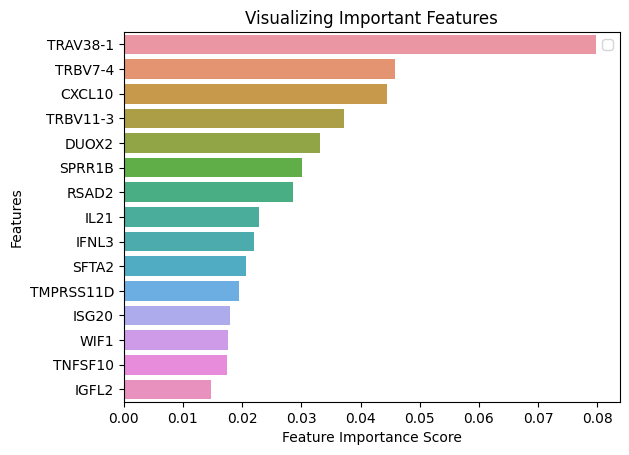

In [32]:
feature_importance_final=(np.array(feature_importance_values[0])+np.array(feature_importance_values[1])+np.array(feature_importance_values[2])+np.array(feature_importance_values[3])+np.array(feature_importance_values[4]))/5

print(len(feature_importance_final))

feature_importance_final_feature=[]

for final_index in range(0, len(feature_importance_final)):
    feature_importance_final_feature.append((feature_importance_final[final_index], top_gene2[final_index]))
    
feature_importance_final_feature.sort(key = lambda x: x[0], reverse=True)
print(feature_importance_final_feature)
print(feature_importance_final_feature[0:15])

important_gene=[]
important_score=[]

for final_index2 in range(0, len(feature_importance_final_feature[0:15])):
    important_score.append(feature_importance_final_feature[0:15][final_index2][0])
    important_gene.append(feature_importance_final_feature[0:15][final_index2][1])
    
print(important_gene)

import seaborn as sns
from matplotlib import pyplot as plt
# %matplotlib inline
sns.barplot(x=important_score, y=important_gene) # creating a bar plot of feature importance

# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

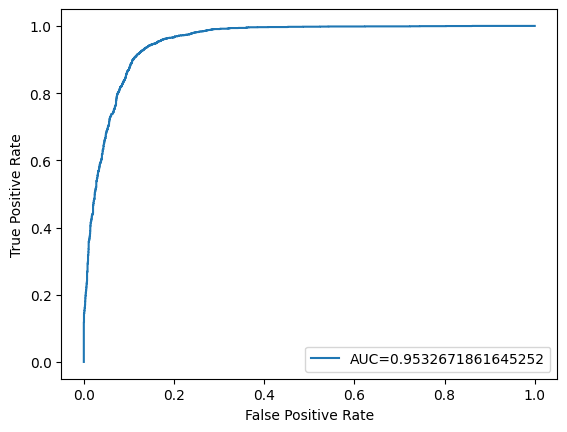

F1-score of SVM 0.8933656248081288
confusion matrix of SVM
[[2292  495]
 [ 119 2891]]


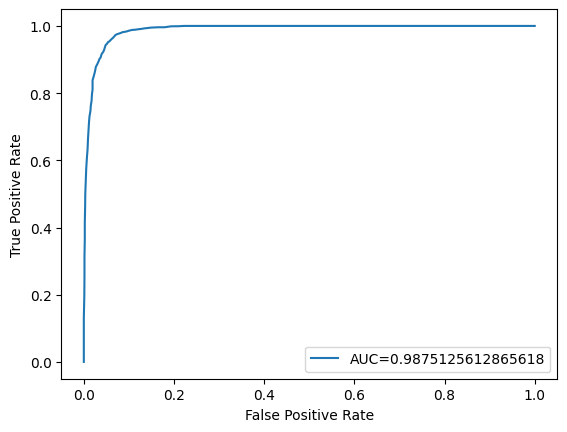

F1-score of random forest 0.9489985453542438
confusion matrix of RF
[[2548  239]
 [  56 2954]]


In [33]:
X_test_new2 = X_test.iloc[:, index2] # retain only the top n features in the data
test_pred2 = clf_select2.predict(X_test_new2)  
f1_select2 = f1_score(y_test, test_pred2, average='weighted')
y_pred_proba3 = clf_select2.predict_proba(X_test_new2)[::,1]
fpr3, tpr3, _ = metrics.roc_curve(y_test,  y_pred_proba3, pos_label="Normal")
auc3 = metrics.roc_auc_score(y_test, y_pred_proba3)
plt.plot(fpr3,tpr3,label="AUC="+str(auc3))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

print("F1-score of SVM "+str(f1_select2))
print("confusion matrix of SVM")
print(confusion_matrix(y_test, test_pred2))

test_pred2_rf = clf_rf2.predict(X_test_new2)
f1_rf2 = f1_score(y_test, test_pred2_rf, average='weighted')
y_pred_proba4 = clf_rf2.predict_proba(X_test_new2)[::,1]
fpr4, tpr4, _ = metrics.roc_curve(y_test,  y_pred_proba4, pos_label="Normal")
auc4 = metrics.roc_auc_score(y_test, y_pred_proba4)
plt.plot(fpr4,tpr4,label="AUC="+str(auc4))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
print("F1-score of random forest "+str(f1_rf2))
print("confusion matrix of RF")
print(confusion_matrix(y_test, test_pred2_rf))

### Load cross validation and testing data for mild vs severe using the intersection of genes from top 100 DEGs of normal vs COVID and mild vs severe

In [34]:
X_train2 = [[] for x in range(num_folds)] # make list of arrays to hold X data for each cell
X_validation2 = [[] for x in range(num_folds)] # make list of arrays to hold X data for each cell
y_train2 = [[] for x in range(num_folds)] # make list of arrays to hold X data for each cell
y_validation2 = [[] for x in range(num_folds)] # make list of arrays to hold X data for each cell

X_test2 = pd.read_csv('mild_vs_severe_test_data.csv')
y_test2 = pd.read_csv('mild_vs_severe_test_label.csv')
y_test2 = np.array(y_test2.drop(columns=['Unnamed: 0']))

for i4 in range(num_folds):
    X_filename3 =  str(i4+1) + '_fold_training_new' + '.csv'
    y_filename3 = str(i4+1) + '_fold_training_label_new' + '.csv'

    X_train_temp2 = pd.read_csv(X_filename3)
    y_train_temp2 = pd.read_csv(y_filename3)

    # Drop unnecessary columns
    y_train_temp2 = np.array(y_train_temp2.drop(columns=['Unnamed: 0']))

    
    X_filename4 =  str(i4+1) + '_fold_testing_new' + '.csv'
    y_filename4 = str(i4+1) + '_fold_testing_label_new' + '.csv'

    X_validation_temp2 = pd.read_csv(X_filename4)
    y_validation_temp2 = pd.read_csv(y_filename4)

    # Drop unnecessary columns
    y_validation_temp2 = np.array(y_validation_temp2.drop(columns=['Unnamed: 0']))
    
    X_train2[i4] = X_train_temp2
    y_train2[i4] = y_train_temp2
    X_validation2[i4] = X_validation_temp2
    y_validation2[i4] = y_validation_temp2


### Cell-level classification of mild and severe using SVM and random forest

In [35]:
SVM_f1_cv2=[]
rf_f1_cv2=[]

for i5 in range(num_folds):
    print("fold "+str(i5+1))
    X_train_new3 = X_train2[i5].iloc[:, index] # retain only the top n features in the data
    X_validation_new3 = X_validation2[i5].iloc[:, index] # retain only the top n features in the data
    
    clf_select3 = SVC(kernel= 'rbf', class_weight='balanced', probability=True)
    clf_select3.fit(X_train_new3, y_train2[i5])  
    validation_pred3 = clf_select3.predict(X_validation_new3)  

    f1_select3 = f1_score(y_validation2[i5], validation_pred3, average='weighted')
    SVM_f1_cv2.append(f1_select3)
    
    clf_rf3 = RandomForestClassifier(n_estimators = 100)
    clf_rf3.fit(X_train_new3, y_train2[i5])
    validation_pred3_rf = clf_rf3.predict(X_validation_new3)
    f1_rf3 = f1_score(y_validation2[i5], validation_pred3_rf, average='weighted')
    rf_f1_cv2.append(f1_rf3)

print("F1-score of cross validation of SVM "+str(SVM_f1_cv2))
print(sum(SVM_f1_cv2)/len(SVM_f1_cv2))
print(np.std(SVM_f1_cv2))
print("F1-score of cross validation of RF "+str(rf_f1_cv2))
print(sum(rf_f1_cv2)/len(rf_f1_cv2))
print(np.std(rf_f1_cv2))

fold 1
fold 2
fold 3
fold 4
fold 5
F1-score of cross validation of SVM [0.9472128996238934, 0.944102126186808, 0.92470429148486, 0.9502117722587755, 0.9344533072906885]
0.940136879369005
0.009356970365297885
F1-score of cross validation of RF [0.9982170054947022, 0.9976274245203632, 0.9964412275100477, 0.9940613484326348, 0.9982212751856663]
0.9969136562286828
0.0015669652502650724


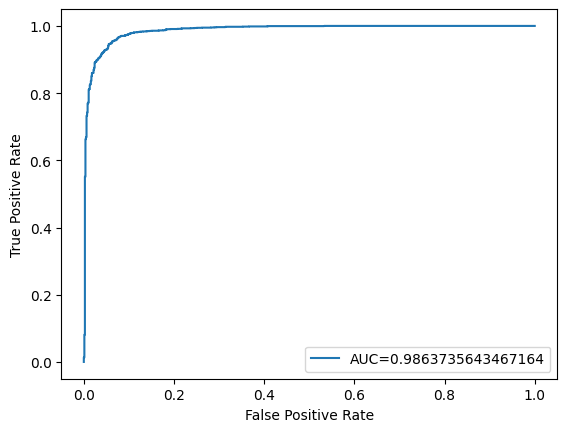

F1-score of SVM 0.9425115706674627
confusion matrix of SVM
[[ 789   46]
 [ 116 1836]]


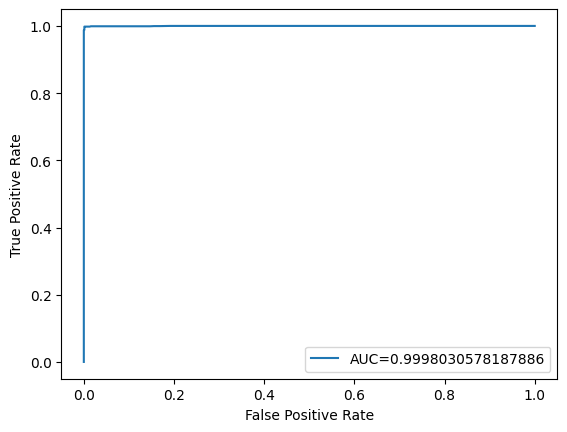

F1-score of random forest 0.9974904770114292
confusion matrix of RF
[[ 834    1]
 [   6 1946]]


In [39]:
X_test_new3 = X_test2.iloc[:, index] # retain only the top n features in the data
test_pred3 = clf_select3.predict(X_test_new3)  
f1_select3 = f1_score(y_test2, test_pred3, average='weighted')
y_pred_proba5 = clf_select3.predict_proba(X_test_new3)[::,1]
fpr5, tpr5, _ = metrics.roc_curve(y_test2,  y_pred_proba5, pos_label="Severe")
auc5 = metrics.roc_auc_score(y_test2, y_pred_proba5)
plt.plot(fpr5,tpr5,label="AUC="+str(auc5))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
print("F1-score of SVM "+str(f1_select3))
print("confusion matrix of SVM")
print(confusion_matrix(y_test2, test_pred3))

test_pred3_rf = clf_rf3.predict(X_test_new3)
f1_rf3 = f1_score(y_test2, test_pred3_rf, average='weighted')
y_pred_proba6 = clf_rf3.predict_proba(X_test_new3)[::,1]
fpr6, tpr6, _ = metrics.roc_curve(y_test2,  y_pred_proba6, pos_label="Severe")
auc6 = metrics.roc_auc_score(y_test2, y_pred_proba6)
plt.plot(fpr6,tpr6,label="AUC="+str(auc6))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
print("F1-score of random forest "+str(f1_rf3))
print("confusion matrix of RF")
print(confusion_matrix(y_test2, test_pred3_rf))

### Load cross validation and testing data for mild vs severe using the union of genes from top 100 DEGs of normal vs COVID and mild vs severe

In [40]:
SVM_f1_cv_new2=[]
rf_f1_cv_new2=[]
feature_importance_values_new = []

for i6 in range(num_folds):
    print("fold "+str(i6+1))
    X_train_new4 = X_train2[i6].iloc[:, index2] # retain only the top n features in the data
    X_validation_new4 = X_validation2[i6].iloc[:, index2] # retain only the top n features in the data
    clf_select4 = SVC(kernel= 'rbf', class_weight='balanced', probability=True)
    clf_select4.fit(X_train_new4, y_train2[i6]) 
    validation_pred4 = clf_select4.predict(X_validation_new4)  
    f1_select4 = f1_score(y_validation2[i6], validation_pred4, average='weighted')
    SVM_f1_cv_new2.append(f1_select4)
    
    clf_rf4 = RandomForestClassifier(n_estimators = 100)
    clf_rf4.fit(X_train_new4, y_train2[i6])
    validation_pred4_rf = clf_rf4.predict(X_validation_new4)
    f1_rf4 = f1_score(y_validation2[i6], validation_pred4_rf, average='weighted')
    rf_f1_cv_new2.append(f1_rf4)
    
    # Save feature importance values from each fold 
    feature_importance_values_new.append(clf_rf4.feature_importances_)

print("F1-score of cross validation of SVM "+str(SVM_f1_cv_new2))
print(sum(SVM_f1_cv_new2)/len(SVM_f1_cv_new2))
print(np.std(SVM_f1_cv_new2))
print("F1-score of cross validation of RF "+str(rf_f1_cv_new2))
print(sum(rf_f1_cv_new2)/len(rf_f1_cv_new2))
print(np.std(rf_f1_cv_new2))

fold 1
fold 2
fold 3
fold 4
fold 5
F1-score of cross validation of SVM [0.9534970992550574, 0.9580114430994578, 0.9530064919673823, 0.9612639419988376, 0.9547007560872982]
0.9560959464816067
0.0031184161780587493
F1-score of cross validation of RF [0.9994063434832382, 0.9988137122601815, 0.9994067000706325, 0.9994067236917206, 0.9988138092709136]
0.9991694577553373
0.0002904254088795141


No handles with labels found to put in legend.


154
[(0.09251514327147159, 'AC114291.1'), (0.08471155068597527, 'TRAV38-1'), (0.07519371554637069, 'DUOX2'), (0.07360818723824405, 'TRDV3'), (0.056632913855535, 'TRBV7-4'), (0.04140879513495145, 'IL21'), (0.0358617973802943, 'KRT81'), (0.03426969901246883, 'IFNL3'), (0.024949483397489713, 'KRT78'), (0.024432573982037985, 'TRAV38-2DV8'), (0.02086287772163051, 'SPRR1B'), (0.020644937444326536, 'IFNL2'), (0.01978809140278231, 'TRAV6'), (0.01869614581780429, 'IGLV5-48'), (0.014616079844842847, 'SFTA2'), (0.013180645138592864, 'IER3'), (0.013005265362031332, 'TMPRSS11D'), (0.011274929292974151, 'FNIP2'), (0.010896293522059916, 'TMPRSS11A'), (0.010509881398385781, 'TRBV10-1'), (0.010157663626997696, 'PLA2G7'), (0.010108866164622256, 'SPP1'), (0.010081626541782334, 'AQP1'), (0.00954156354978717, 'CCR4'), (0.009217168878724726, 'GCNT3'), (0.009050056161033167, 'RAB25'), (0.008925710478900542, 'PRSS2'), (0.008253397689638533, 'IGFL1'), (0.007503828730033753, 'AC242022.1'), (0.007425344647184531

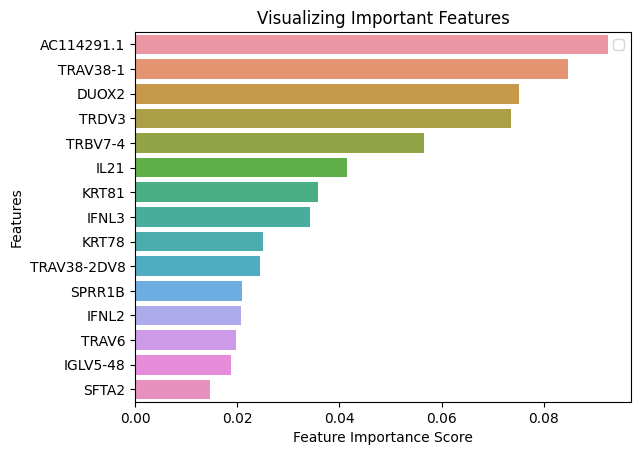

In [41]:
feature_importance_final2=(np.array(feature_importance_values_new[0])+np.array(feature_importance_values_new[1])+np.array(feature_importance_values_new[2])+np.array(feature_importance_values_new[3])+np.array(feature_importance_values_new[4]))/5

print(len(feature_importance_final2))

feature_importance_final_feature2=[]

for final_i in range(0, len(feature_importance_final2)):
    feature_importance_final_feature2.append((feature_importance_final2[final_i], top_gene2[final_i]))
    
feature_importance_final_feature2.sort(key = lambda x: x[0], reverse=True)
print(feature_importance_final_feature2)
print(feature_importance_final_feature2[0:15])

important_gene2=[]
important_score2=[]

for final_index3 in range(0, len(feature_importance_final_feature2[0:15])):
    important_score2.append(feature_importance_final_feature2[0:15][final_index3][0])
    important_gene2.append(feature_importance_final_feature2[0:15][final_index3][1])
    
print(important_gene2)

import seaborn as sns
from matplotlib import pyplot as plt
# %matplotlib inline
sns.barplot(x=important_score2, y=important_gene2) # creating a bar plot of feature importance

# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

### Cell-level classification of mild and severe using SVM and random forest

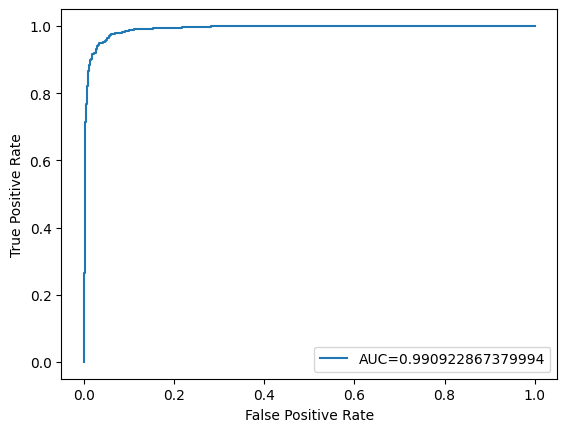

F1-score of SVM 0.9582471759749418
confusion matrix of SVM
[[ 793   42]
 [  75 1877]]


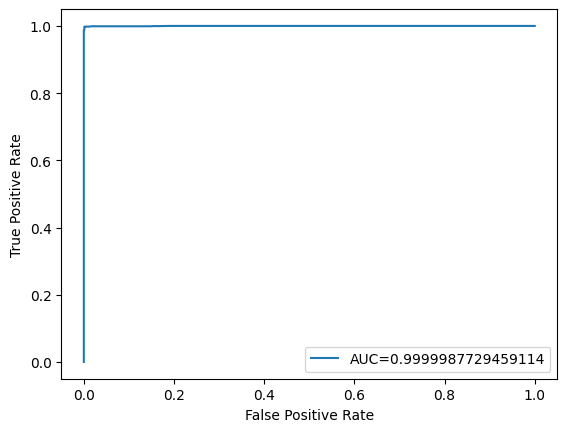

F1-score of random forest 0.997849344134951
confusion matrix of RF
[[ 835    0]
 [   6 1946]]


In [42]:
X_test_new4 = X_test2.iloc[:, index2] # retain only the top n features in the data
test_pred4 = clf_select4.predict(X_test_new4)  
f1_select4 = f1_score(y_test2, test_pred4, average='weighted')
y_pred_proba7 = clf_select4.predict_proba(X_test_new4)[::,1]
fpr7, tpr7, _ = metrics.roc_curve(y_test2,  y_pred_proba7, pos_label="Severe")
auc7 = metrics.roc_auc_score(y_test2, y_pred_proba7)
plt.plot(fpr7,tpr7,label="AUC="+str(auc7))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
print("F1-score of SVM "+str(f1_select4))
print("confusion matrix of SVM")
print(confusion_matrix(y_test2, test_pred4))

test_pred4_rf = clf_rf4.predict(X_test_new4)
f1_rf4 = f1_score(y_test2, test_pred4_rf, average='weighted')
y_pred_proba8 = clf_rf4.predict_proba(X_test_new4)[::,1]
fpr8, tpr8, _ = metrics.roc_curve(y_test2,  y_pred_proba8, pos_label="Severe")
auc8 = metrics.roc_auc_score(y_test2, y_pred_proba8)
plt.plot(fpr6,tpr6,label="AUC="+str(auc8))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
print("F1-score of random forest "+str(f1_rf4))
print("confusion matrix of RF")
print(confusion_matrix(y_test2, test_pred4_rf))